<a href="http://www.stfc.ac.uk/"> <img src="../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


In [22]:
import sys
import math
import numpy
sys.path.append('../lib/')
#import addopt, addopt_model, Kernel
import Kernel

from sklearn import svm
from sklearn import gaussian_process, linear_model
from sklearn.kernel_ridge import KernelRidge
import sklearn.gaussian_process.kernels as kernels
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from rdkit import Chem
import pandas, pickle

import matplotlib.pyplot as plt
%matplotlib notebook
'imported'

'imported'

# Exercise 1: Building a regression model for solubilties.

* You may use descriptors or fingerprints
    - To use descriptors, you will need to use training_molecule to gather the descriptors. To use fingerprints, the fingerprints and gram matrix is already given.
* You may use a single or combined model

To load in data: 

      with open( "../model_data/solubility_gm.p", 'rb' ) as f:  
             (training_fp, training_gm, training_y, test_fp, test_gm, test_y, training_molecule, test_molecule) =             
                 pickle.load(f)



<IPython.core.display.Javascript object>


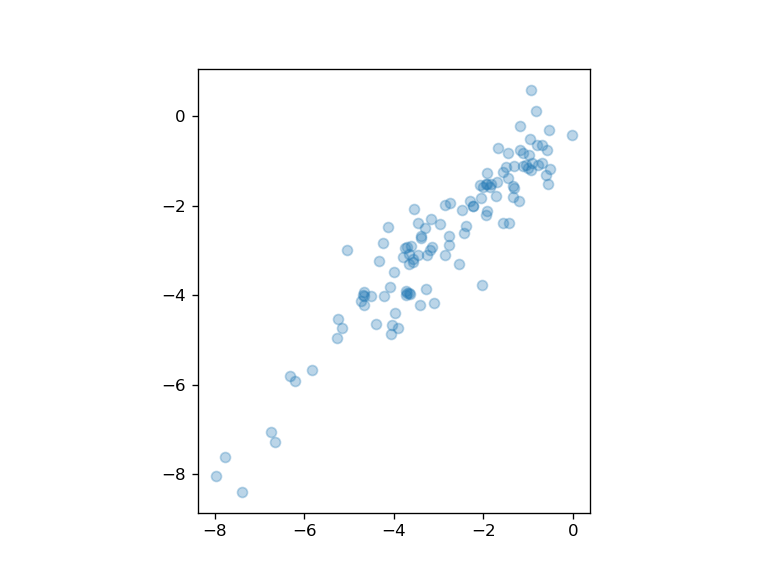

In [18]:
with open( "../model_data/solubility_gm_rdk835.p", 'rb' ) as f:  
     (training_fp1, training_gm1, training_y1, test_fp1, test_gm1, test_y1, 
      training_molecule1, test_molecule1) = pickle.load(f)
with open( "../model_data/solubility_gm_path.p", 'rb' ) as f:  
     (training_fp2, training_gm2, training_y2, test_fp2, test_gm2, test_y2, 
      training_molecule2, test_molecule2) = pickle.load(f)
with open( "../model_data/svr_path.p", "rb" ) as f:
    model2 = pickle.load(f )
with open( "../model_data/svr_rdk835.p", "rb" ) as f:
    model1 = pickle.load(f )
    
assert (test_y1 == test_y2).all()
    
pred1 = model1.predict(test_gm1)
pred2 = model2.predict(test_gm2)

plt.figure()
plt.axes().set_aspect('equal')
plt.scatter(pred1, pred2, alpha=0.3)

In [25]:
list( zip(model1.predict(training_gm1), model2.predict(training_gm2)) )

[(-3.024447600726378, -2.750904474645493),
 (-1.1755724190473416, -0.6328528143203191),
 (-3.172797684664518, -2.9317786860895962),
 (-3.3505221938079988, -3.114914502067794),
 (-3.605407707308028, -3.67001015694724),
 (-4.344879011127478, -4.214227773049868),
 (-4.0227820784414146, -4.204329850082486),
 (-4.675452706803931, -4.8403366764293185),
 (-1.859495166401163, -1.3990779080636973),
 (-1.529926890285806, -1.1635489990720567),
 (-0.10180239773174593, -0.220201120609804),
 (-3.9018915631219873, -4.073685316013625),
 (-3.8733209399538167, -3.8577055324769463),
 (-3.081047581367651, -2.0819487648221426),
 (-4.185845456586816, -4.780219319663194),
 (-3.8065613911267437, -3.9082595305650436),
 (-8.010107401645286, -7.888911574350732),
 (-6.441915569651405, -7.041154214621975),
 (-3.5575038749408057, -3.7619525703241337),
 (-4.666426443120055, -4.161035699343247),
 (-0.7937492202239538, -1.2183245151759112),
 (0.27899961721704747, -0.7553690598342017),
 (-0.9081838269608162, -0.7329228

<IPython.core.display.Javascript object>


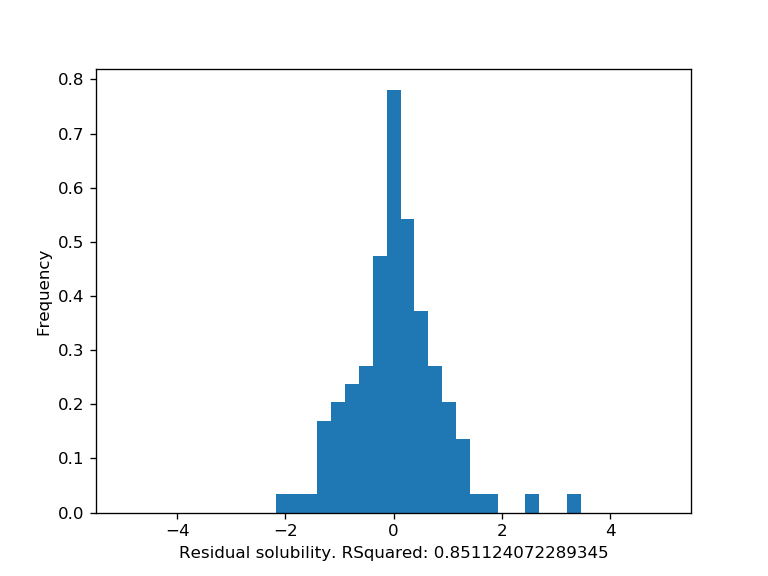

In [26]:


model = linear_model.LinearRegression(fit_intercept=True, normalize=False)

model.fit(
   list( zip(model1.predict(training_gm1), model2.predict(training_gm2)) ),
   training_y1
)

predicted = model.predict(
    list( zip(pred1, pred2) )
) #[ (y1+y2)/2 for y1, y2 in zip(pred1, pred2) ]


residuals = test_y1 - predicted
# rmse = math.sqrt(mean_squared_error(y, predicted))
rsquare = r2_score(test_y1,predicted)

                
# display results
plt.figure()
plt.xlabel('Residual solubility. RSquared: {}'.format(rsquare))
plt.ylabel('Frequency')
plt.hist(residuals, bins=numpy.linspace(-5, 5, 40), normed=1)
plt.show()

# Exercise 2 (Harder): Building a regression model to predict lipophilicity

Thanks to Igor Tetko for these data. See http://dx.doi.org/10.1002/jps.21494 and https://ochem.eu/.

* You may use descriptors or fingerprints
    - Neither of these are given, but the RDKit molecule is already available in the pickle file.
* You may use a single or combined model

       training_data = pandas.read_pickle("../model_data/logP_train.p")
       test_data = pandas.read_pickle("../model_data/logP_test.p")

In [23]:
training = pandas.read_pickle("../model_data/logP_train.p")
test_set = pandas.read_pickle("../model_data/logP_test.p")

Support Vector Regression 
==============

In [24]:
from sklearn import utils


kernel = Kernel.MoleculeKernel()

# see http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html
model = svm.NuSVR(kernel='precomputed', 
                tol=1e-3, # tolerance for stopping, should match experimental error
                # C=1, # lower values imply more regularization
                nu=0.5, # default is 0.5
) 

# Can be slow. Time is square of size of training set.
training_gm = kernel(training.molecule) # Gram matrix

model.fit(
        training_gm, # precomputed
        training['y'],  # dependent values, to be predicted
        # weights=, metric=
)

predicted = model.predict( kernel(test_set.molecule, training.molecule) )
residuals = test_set['y'] - predicted
rsquare = r2_score(test_set['y'],predicted)

print('Number of support vectors: {}  R Squared: {}'.format( len(model.support_), rsquare ))

Number of support vectors: 120  R Squared: 0.4175397960094619


That's a dreadful result. Choose some other method and apply it. To help you, code for a grid search is below.

In [25]:
from sklearn.model_selection import GridSearchCV

#let's use 10-fold cross validation, iterating through a range of values for nu and C.

parameters = {
    # select a suitable parameter and range
}

grid_search = GridSearchCV(model,parameters,cv=10, scoring="r2", return_train_score=True)
grid_search.fit(training_gm,training['y'])
grid_search.best_estimator_

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='auto',
   kernel='precomputed', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

## Visualize the results of the grid search

In [ ]:
results = grid_search.cv_results_

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#best_nu = parameters['nu'][ numpy.where(mean_accuracy_scores==max_accuracy)[0][0] ]

ax.plot_trisurf(
    results["param_name"].data.tolist(), #change this to correct param name
    results["param_name"].data.tolist(), #change this to correct param name
    results["mean_train_score"], 
    alpha=0.2, color='red'
)
ax.plot_trisurf(
    results["param_nu"].data.tolist(),
    results["param_C"].data.tolist(),
    results["mean_test_score"], 
    alpha=0.2, color='blue'
)

#plt.scatter(parameters['nu'],mean_accuracy_scores)
ax.set_xlabel("Nu")
ax.set_ylabel("C")
ax.set_zlim(0,1)
ax.set_zlabel('R Squared')
ax.mouse_init()
plt.show()

print("Optimised model is:\n {} \nR**2 {}".format(grid_search.best_estimator_, max(grid_search.cv_results_["mean_test_score"])))

<div class="alert alert-warning" role="alert">
<b>Discussion:</b> Which is the best method for this dataset?<br>
<b>Advanced exercise:</b> Repeat this exercise with the dataset  raw_data/JCICS2003_mtp_train.csv and  raw_data/JCICS2003_mtp_test.csv. Thanks to Bergstrom et al. for these data. </div>

See: Bergstrom, C. A. S.; Norinder, U.; Luthman, K.; Artursson, P. *Molecular Descriptors Influencing Melting Point and Their Role in Classification of Solid Drugs.* J. Chem. Inf. Comput. Sci.; (Article); 2003; 43(4); 1177-1185